In [42]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append(os.path.abspath(".."))   # one level up
import numpy as np
import cv2
import open3d as o3d
from scipy.spatial.transform import Rotation
from utils.lidar import PointCloud
from utils.camera import ImageData
import utils.utils as utils
from natsort import natsorted

In [43]:
# User parameters
location = 'Holmview'
# location = 'Cambogan'

################ Query filenames and directories #################################
qry_sequence = '20250820_130327'
# qry_sequence = '20250811_113017'
qry_condition = 'flooded'
qry_camera_pos = 'front'
qry_root_directory = f"../../Datasets/FRED/{qry_condition}/KITTI-style"

qry_image_dir = f"{qry_root_directory}/{location}_{qry_sequence}/{qry_camera_pos}-imgs/"
qry_utm_dir = f"{qry_root_directory}/{location}_{qry_sequence}/utm/"
qry_timestamps = [filename.split('.png')[0] for filename in natsorted(os.listdir(qry_image_dir)) if os.path.isfile(qry_image_dir+filename)]

################ Reference filenames and directories #################################
ref_sequence = '20250812_120100'
# ref_sequence = '20250812_122339'
ref_condition = 'dry'
ref_camera_pos = 'front'
ref_root_directory = f"../../Datasets/FRED/{ref_condition}/KITTI-style"

ref_image_dir = f"{ref_root_directory}/{location}_{ref_sequence}/{ref_camera_pos}-imgs/"
ref_utm_dir = f"{ref_root_directory}/{location}_{ref_sequence}/utm/"
ref_utms = np.array([np.loadtxt(ref_utm_dir+filename) for filename in natsorted(os.listdir(ref_utm_dir)) if os.path.isfile(ref_utm_dir+filename)])
ref_utm_filenames = np.array([filename for filename in natsorted(os.listdir(ref_utm_dir)) if os.path.isfile(ref_utm_dir+filename)])
ref_img_filenames = [filename for filename in natsorted(os.listdir(ref_image_dir)) if os.path.isfile(ref_image_dir+filename)]

img_calib_file = f"../camera_calib.txt"

dist_tolerance = 10 # metres
qry_idx = 100

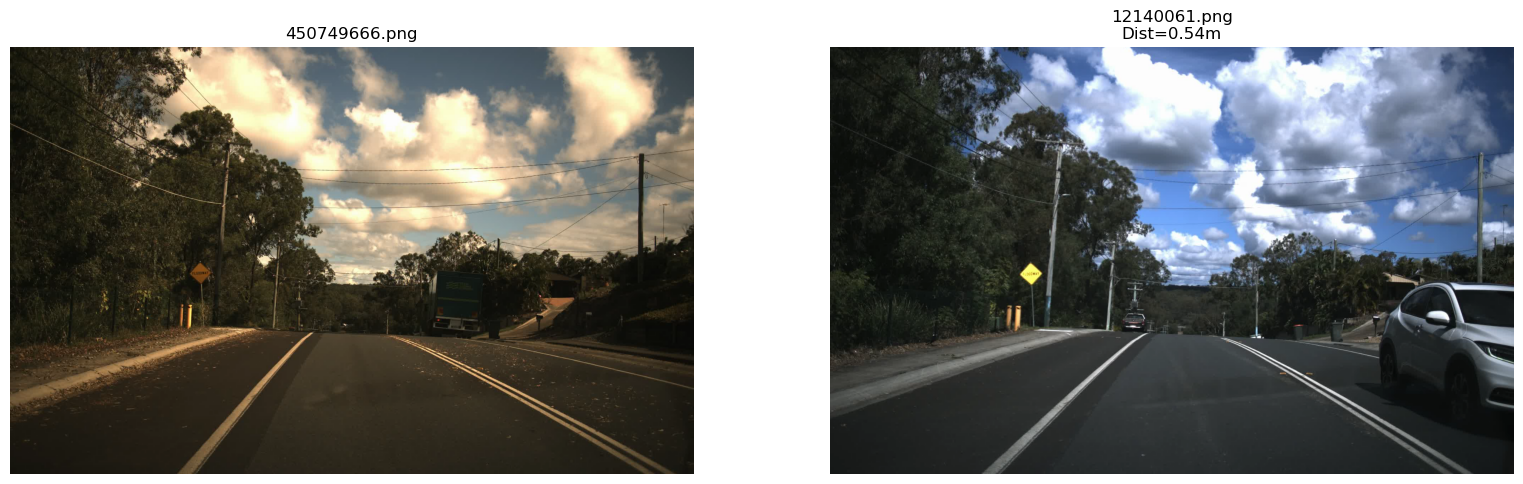

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(19.4, 6))
ax[0].clear()
ax[1].clear()

qry_image_timestamp = qry_timestamps[qry_idx]
qry_image_filename = f"{qry_image_dir}/{qry_image_timestamp}.png"
qry_utm_timestamp = utils.get_corr_files(qry_image_timestamp, [qry_utm_dir,])
qry_utm = np.loadtxt(qry_utm_timestamp)


diffs = ref_utms - qry_utm           # shape (N, 2)
dists = np.linalg.norm(diffs, axis=1)   # shape (N,)
closest_idx = np.argmin(dists)
closest_dist = dists[closest_idx]

qry_image = ImageData(qry_image_filename, img_calib_file)

ax[0].imshow(qry_image.image[:, :, ::-1])
ax[0].set_title(f"{qry_image_timestamp}.png")
ax[0].axis("off")

if closest_dist <= dist_tolerance:
        # Show matching reference image
        ref_img_timestamp = utils.get_corr_files(ref_utm_filenames[closest_idx].split('.txt')[0], [ref_image_dir,])
        ref_image = ImageData(ref_img_timestamp, img_calib_file)
        ax[1].imshow(ref_image.image[:, :, ::-1])
        ax[1].set_title(f"{ref_img_timestamp.split('/')[-1]}\nDist={closest_dist:.2f}m")
else:
    # Show black image with message
    black_img = np.zeros_like(qry_image.image)
    ax[1].imshow(black_img)
    ax[1].text(
        0.5, 0.5, "No reference image found\nwithin distance tolerance",
        color="white", fontsize=16, ha="center", va="center", transform=ax[1].transAxes
    )
    ax[1].set_title(f"No Match (min dist={closest_dist:.2f}m)")

ax[1].axis("off")
fig.canvas.draw()